In [1]:
%pylab
from IPython import display
import scipy.special as spe
import scipy.optimize as opt
import scipy.integrate as integrate

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


In [2]:
#analytic velocity determination

# the substrate will have a different length for each potential steady state velocity
def xsf(v,t):
    dx = 0.1
    travel = abs(v*t)
    if travel < 10.0:          # I found that if the velocity was low enough v*t could not capture all the relevant values 
        length = 10.0          # min_length used if substrate not long enough for small speeds 
    else:
        length =travel 
    return linspace(-length, 10.0, int(2*length/dx) + 1) 

#function to determine the bound complex concentration as function of x
def a_c(v, xs,a0,nu,tc): 
    Nx = len(xs)
    Ac = zeros(Nx)            #will fill this array with calculated values when function is called

    #the only way I could think to set up this integral without actual values of v
    integrand = lambda t: exp(nu*t)*exp(-0.5*(xs[i]-v*t)**2)* a0* exp(sqrt(pi/2)*(spe.erf((xs[i] - v * t)/sqrt(2))-1)/v)

    #assign values to Ac for each point in space depending on: v, xs, nu and a0
    for i in range(Nx):
        Ac[i] = sci.quad(integrand, tc, 0 )[0]
    return Ac

# parameters
a0_n = 10
nu_n = 15

a0s = logspace(-4, 3, a0_n, base=2)
nus = logspace(-5, 3, nu_n, base=2)


v_a0 = []            #list that stores finalvelocity(a0)
for a0  in a0s:          # look at each a0 value 
    print(". . . a0: ", a0)
    v_nu = []            #list that stores finalvelocity(nu)
    for nu in nus:       # look at each nu value
        
        print("nu: ", nu)
        tc = log(1e-8)/nu        #cutoff time for integration, must satisfy e^(tc*nu) <= 1e-8
    
        

        #the transendental equation of which we need roots 
        f = lambda v: v - trapz(xsf(v,tc)*a_c(v,xsf(v,tc),a0,nu,tc), x = xsf(v,tc)) 

        #1e-8-2.0 is the guessed at range for possible speeds, 
        #but just to make sure use a try to make sure we don't get an error
        try:
            speed = opt.brentq(f, 1e-8,2.0) 
            print("hub speed: ", speed)
        except:
            print("no zero found")
            speed = nan
        
        v_nu.append(speed)
    v_a0.append(v_nu)        # will compare with numerical solutions later on

. . . a0:  0.0625
nu:  0.03125


<ipython-input-2-6c275bc2fa85>:23: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  Ac[i] = sci.quad(integrand, tc, 0 )[0]


hub speed:  0.053671267227609
nu:  0.04643732153552963
hub speed:  0.06489834883733507
nu:  0.06900559460461327
hub speed:  0.06954719598230179
nu:  0.10254191950095475
hub speed:  0.05681059333969195
nu:  0.15237670677555942
hub speed:  0.020690005250915966
nu:  0.2264309160659766
hub speed:  0.0006130220840686786
nu:  0.336475048158089
hub speed:  1.5897330907129197e-07
nu:  0.5
no zero found
nu:  0.7429971445684741
no zero found
nu:  1.104089513673812
no zero found
nu:  1.640670712015275
no zero found
nu:  2.4380273084089508
no zero found
nu:  3.6228946570556255
no zero found
nu:  5.383600770529422
no zero found
nu:  8.0
no zero found
. . . a0:  0.1071554978566341
nu:  0.03125
hub speed:  0.05899466673237692
nu:  0.04643732153552963
hub speed:  0.07617709466585797
nu:  0.06900559460461327
hub speed:  0.0928099862649234
nu:  0.10254191950095475
hub speed:  0.10169047058207431
nu:  0.15237670677555942
hub speed:  0.08909659300469024
nu:  0.2264309160659766
hub speed:  0.04311241339034

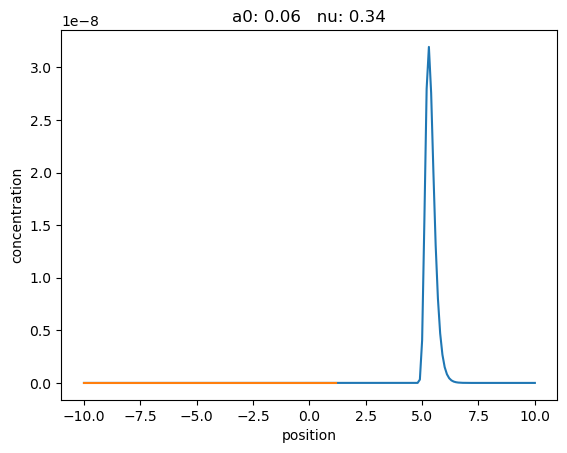

substrate is good


ValueError: cannot convert float NaN to integer

In [3]:
#check that substrate was long enough so that all Ac >= 1e-8 is used in integration

for i in range(a0_n):
    for j in range(nu_n):
        speed = v_a0[i][j] 
        testxs = xsf(speed,tc)
        testAc = a_c(speed,testxs,a0s[i],nus[j],tc)
        testAs = a0s[i] * exp((sqrt(pi/2)*spe.erf((testxs)/sqrt(2))-1)/speed) # want these values at t=0


        if testAc[0] < 1e-8 and testAc[-1] < 1e-8: # just check end points
            print("substrate good")
            display.clear_output(wait=True)
            plot(testxs,testAc) # just to have a look
            plot(testxs,testAs)
            title("a0: "+str(round(a0s[i],2)) + "   nu: "+str(round(nus[j],2)))
            ylabel("concentration")
            xlabel("position")
            display.display(gcf())
            cla()
            input("substrate is good")
        else: 
            input("substrate not long enough")
        

In [16]:
#Euler numerical method

tf = 400.0 # max time that the simulation will run 

# parameters
a0_n = 10
nu_n = 15

a0s = logspace(-4, 3, a0_n, base=2)

nus = logspace(-5, 3, nu_n, base=2)

# define domain and lattice
Lmax = 30.0 
Lmin = -10.0
dx = 0.1
Nx = int((Lmax-Lmin)/dx) +1
xs = linspace(Lmin, Lmax, Nx)


e_a0 = []
for a0 in a0s: #solve the equations for each parameter value
    print(". . .  a0:  ", a0)
    e_nu = []
    for nu in nus:
        print("nu: ", nu)
        

        # initialize As and Ac for each run through
        As = zeros(Nx)
        As[xs > 0.0] = a0*1.0
        Ac = zeros(Nx)
        xp = zeros(1)


        dt = 0.001
        t_max = int(tf/dt)
        v_t = []
        for t in range(t_max): # loop through for every time step
            # first determine total force on hub
            fi = -(xp -xs) * Ac
            total_f = trapz(fi, x=xs)
            #THEN update As and Ac
            binding = exp(-0.5 * (xp - xs) ** 2) * As
            burnt = nu * Ac
            Ac += (binding - burnt) * dt
            As += - binding * dt
            xp += total_f*dt # NOW move hub
            v_t.append(total_f) # store the velocities at each time step
            if xp >= 20.0:
                break
            
        e_nu.append([v_t,t])
    e_a0.append(e_nu)

. . .  a0:   1.0
nu:  0.03125
nu:  0.04643732153552963
nu:  0.06900559460461327
nu:  0.10254191950095475
nu:  0.15237670677555942
nu:  0.2264309160659766
nu:  0.336475048158089
nu:  0.5
nu:  0.7429971445684741
nu:  1.104089513673812
nu:  1.640670712015275
nu:  2.4380273084089508
nu:  3.6228946570556255
nu:  5.383600770529422
nu:  8.0


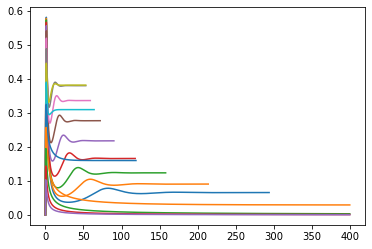

In [17]:
# a quick look at the velocity curves to convince myself that the numerical simulations reach a steady state
for i in range(nu_n):
    t_max = e_a0[0][i][1]+1
    tf = int(t_max*dt)
    plot(linspace(0,tf,t_max),e_a0[0][i][0], label = str(round(nus[i],2)))
#legend()
    

In [4]:
#BDF numerical method
# used the core of Eldon's example code

tf = 400.0 # max time that the simulation will run 


#parameters 
a0_n = 10
nu_n = 15

a0s = logspace(-4, 3, a0_n, base=2)

nus = logspace(-5, 3, nu_n, base=2)

# define domain and lattice
Lmax = 30.0 
Lmin = -10.0
dx = 0.1
Nx = int((Lmax-Lmin)/dx) +1
xAs = linspace(Lmin, Lmax, Nx)

# define event as having gone to x = 20.0
def event(t, y):
    x0 = y[0]
        
    return 20.0-x0

event.direction = 0        
event.terminal = True     # stop solver if event satisfied


# returns vector of dx/dt, dAcx/dt and dAx/dt in that order

def derivs(t, y, nu, xAs):
    x0 = y[0]               # position of hub
    N = int(0.5*(len(y)-1))   # of lattice sites
    Acx = y[1:N+1]          # bound complex on lattice
    Ax = y[-N:]             # free complex on lattice
    
    dxcdt = integrate.trapz(-(x0-xAs)*Acx, x=xAs)  # force equation
    binding = exp(-0.5*(x0-xAs)**2)*Ax 
    burnt = nu*Acx

    dAcxdt = (binding - burnt)   # complex chemistry
    dAxdt = -binding            # free substrate chemistry
    
    return array( [dxcdt] + list(dAcxdt) + list(dAxdt))     # maybe a better way to put them all together


#I.C.

v_a0n = []  # record final speed
for a0 in a0s:
    
    A0x = zeros(Nx)
    A0x[xAs > 0.0] = a0
    # A0x = a0*ones(Nx) + 0.1*a0*2.0*(0.5-random.random(Nx))

    # iterate over params
    v_nu = []
    for nu in nus:
        print(a0, nu)

        x0 = 0.0
        Ax = 1.0*A0x
        Acx = zeros(Nx)

        # initial conditions for all the equations, y0
        y0 = array([x0] + list(Acx) + list(Ax))
        
        #Rk45 and other methods create in v(t) oscillations for nu << a0
        sol = integrate.solve_ivp(lambda t, y: derivs(t, y, nu, xAs), (0.0, tf), y0, events=[event], method='BDF')
        
        #get the velocity curves
        v_t = []
        ts = []
        for t in range(len(sol.t)):
            v_t.append(derivs(sol.t[t], sol.y[:,t], nu, xAs)[0])
            ts.append(sol.t[t])
        
        
        v_nu.append([v_t,ts])
    v_a0n.append(v_nu)

0.0625 0.03125
0.0625 0.04643732153552963
0.0625 0.06900559460461327
0.0625 0.10254191950095475
0.0625 0.15237670677555942
0.0625 0.2264309160659766
0.0625 0.336475048158089
0.0625 0.5
0.0625 0.7429971445684741
0.0625 1.104089513673812
0.0625 1.640670712015275
0.0625 2.4380273084089508
0.0625 3.6228946570556255
0.0625 5.383600770529422
0.0625 8.0
0.1071554978566341 0.03125
0.1071554978566341 0.04643732153552963
0.1071554978566341 0.06900559460461327
0.1071554978566341 0.10254191950095475
0.1071554978566341 0.15237670677555942
0.1071554978566341 0.2264309160659766
0.1071554978566341 0.336475048158089
0.1071554978566341 0.5
0.1071554978566341 0.7429971445684741
0.1071554978566341 1.104089513673812
0.1071554978566341 1.640670712015275
0.1071554978566341 2.4380273084089508
0.1071554978566341 3.6228946570556255
0.1071554978566341 5.383600770529422
0.1071554978566341 8.0
0.18371681153444983 0.03125
0.18371681153444983 0.04643732153552963
0.18371681153444983 0.06900559460461327
0.183716811534

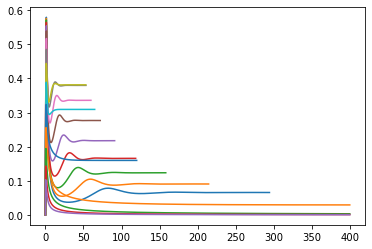

In [9]:
# a quick look at the velocity curves to convince myself that the numerical simulations reach a steady state
for i in range(nu_n):
    plot(v_a0n[0][i][1],v_a0n[0][i][0], label = str(round(nus[i],2)))
#legend()
    

In [36]:
#probably not the best way to do this but I could not figure out how to work in array operations of the ragged arrays
a0_n = 10
v_final = zeros((a0_n,nu_n))
v_finale = zeros((a0_n,nu_n))
for i in range(a0_n):
    for j in range(nu_n):
        v_final[i][j] = v_a0n[i][j][0][-1]
        #v_finale[i][j] = e_a0[i][j][0][-1]

for i in range(a0_n):
    for j in range(nu_n):
        if isnan(v_a0[i][j]):
            print("true")
            v_a0[i][j] = 0.0
            
colors1 = ["silver", "lightpink", "lightcoral", "peachpuff", "bisque", "lawngreen", "cyan", "skyblue", "blueviolet", "violet"]
colors2 = ["dimgrey", "crimson", "darkred", "peru", "darkorange","forestgreen", "darkturquoise", "deepskyblue", "indigo", "magenta"]
    
#compare the analytic and numeric steady state velocities for a given a0
for i in range(0,a0_n):
    plot(nus, v_a0[i],"-", color = colors1[i], label = r"$a_{tot}$: "+str(round(a0s[i],2)))
    plot(nus, v_final[i],".", color = colors2[i])
    #plot(nus, v_finale[0],".-", label = r"Numeric Euler $a_{tot}$: "+str(round(a0s[0],2)))
    title("Numeric and Analytic Steadystate Velocities")
    xscale("log")
    ylabel("steady state velocity")
    xlabel(r"$\nu'$")
    legend()